# The Many Levels of the Reverend Bayes

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("paper")
from sklearn.metrics import confusion_matrix

##Bayes Theorem

The theorem follows directly from writing the definition of conditional probability in two ways:

$$ p(h|D) = \frac{p(D|h)\,p(h)}{p(D)} $$

This can be read as:

$$ Posterior = \frac{Likelihood \times Prior }{Evidence} $$

###The Cancer Example

Say I go for a lab test. It comes out positive for a type of cancer.

This test is known to have a true positive rate of 98%, that is, for those who have cancer, 98% of the time this test turns out to be positive.

The test is also known to have a true negative rate of 97%, that is for those who dont have cancer, 97% of the time the test turns out to be negative.

This cancer type has a prior probability of 0.8% of occurring in the population.

What should I do?

##Reminder of the structure of learning

Lets focus on supervised learning for a bit to understand what new stuff does Bayes Theorem and Bayesian modelling bring to learning.

(diagram from Abu-Mustafa's Learning From Data Course)
![ml diagram](https://dl.dropboxusercontent.com/u/75194/abumustafa.png)

Lets define 

$$E_{XY}[f(X,Y)] = \int f(x,y) dP_{XY}(x,y) = \int f(x,y) p(x,y)\,dx\,dy$$ where $P$ is the distribution (cdf) and $p$ is the local density. We'll use the Lebesgue measure for continuous rvs and the counting measure for discrete rvs, so as to use the integral symbol everywhere.

Then consider an estimator function (for regression, estimating $f$ per usual) or action (for classification) $g$. The risk accociated with $g$ is:

$$R(g) = E_{XY}[l(g(X),Y)]$$

where $l(g(x),y)$ is the loss associated with choosing action $g$ at x when $Y=y$. For example, for regression we can use $l = (g-y)^2$ and for classification we usually use the 1-0 loss $l = \mathbb{1}_{g \ne y}$.

The idea, as we have seen before is to find an optimal decision function by minimizing the risk (or maximizing a utility). But remember we dont know $P$ and the different kinds of learning use different ways to estimate $P$. Only if our estimated distribution is close to the true $P$ can we expect our decisions to generalize well outside our training set.

Thus there are two games in town: 

1. estimating the density
2. minimizing the risk

### The different kinds of learning

![learning](https://dl.dropboxusercontent.com/u/75194/learning.png)

####ERM 

The Empirical Risk Maximization (ERM) approach corresponds to estimating the true distribution by the empirical distribution. We have seen this before. In this case the Risk R is simply the average of the losses at the individual training points:

$$ R(g) = \frac{1}{N} \sum_i l(g(x_i), y_i) .$$

(next two images from Barber)
![ERM learning](https://dl.dropboxusercontent.com/u/75194/erm.png)

The optimal decision in the training set is obviously the value of $y$ at the training point, but we are left with undefined action $g$ outside the training set. We thus pick some parametric model $g(x;\theta)$. Now we can minimize the empirical risk with respect to $\theta$ to get $\theta_{opt}$ and use this to make predictions/actions using $g$. Because such an approach can lead to overfitting as we have seen before, we typically add a regularization term with co-efficient $\lambda$ whose value is found by validation.

Notice that in all of this any talk of density estimation has gone away, and we are just minimizine the averaged loss over the training set plus regularization, the so-called Structural Risk maximization approach of Vapnik, whose motto is (paraphrased): **Never solve a more difficult problem (density estimation) while solving a difficut one (learning)**. The function $g$ is then sometimes called a discriminant function, and we are choosing it based on *minimal risk, which is the quantity we are ultimately interested in*. 

But there are drawbacks. It seems crazy to assume that the empirical distribution is a good distribution, especially for small data. A more reasonable assumption for the distribution could take into account likely x,y that could arise. If the loss changes, as it might over time, say in a financial application, then we would need to retrain $g$. There is no way to associate a confidence in this framework, as it wont give you probabilities. And we cant acomodate things like the reject option, compensating for assymetric data sets (class priors), or combine models. This is where something like the Naive Bayes model below comes in.

####Bayes
![Bayesian learning](https://dl.dropboxusercontent.com/u/75194/bayesrisk.png)

The alternative is to first do density estimation. We estimate $P(x,y)$ (or $P(x,c)$) from the training data. Note that this can be thought of as ERM on risk $-log(p)$ and can be appropriately regularized in a Bayesian fashion (or be just ML estimation, one can see the different levels at which Bayes might come in). This is usually done parametrically, from which one can construct a sampling (in frequentist) or posterior predictive, or just use the plug-in MAP/MLE estimate. The joint distribution can be constructed in two ways: generative or discriminative. The discriminative approach gives us:

$$p(x,c) = p(c|x)p(x)$$

whereas the generative approach gives us

$$p(x,c) = p(x|c) p(c)$$

and then bayes theorem can be used to obtain p(c|x).

The generative approach corresponds to picking one of the classes with probability p(c) and then getting the density of the features for that class. The discriminative approach models the domain boundary instead. While the data may be distributed in a complex way, the boundary may be easier to model. On the other hand prior information for assymetric situations, conditional independence and other such strategies can only be done in generative models.

![Bayesian learning](https://dl.dropboxusercontent.com/u/75194/genvsdiscrim.png)

In either case we can get the joint distribution. In the discriminative case that leads us to density estimation for $p(x)$. Often we have no use for it so we wont do it, as in logistic regression. But do remember that if we want our classifier to have good results we should be using iton sets which reflect $p(x)$. And if we dont characterize it we might be better of using a generative model as it is easier to adjust for class priors.

The Bayesian decision approach is a clean one, in which first one models the **environment**, independent of the subsequent decision process. If $p(y,x|\theta)$ is the "true" model of the world, this is optimal. But if this **environment model** is poor, the action $g$ could be higly inaccurate since the environment is divorced from prediction. In practice one often includes regularization terms in the environment model to reduce the complexity of the distribution and bring it more in line with decision based hyperparameters, set by validation on an empirical loss. See the cs109 (2013) Naives bayes homework for a good example.

The ERM method is the only **frequentist** method which has a well defined risk. The reason for this is that it dosent depend on both a sample-estimate of the true $\theta$.

##Naive Bayes

This is the second level at which we use a fairly direct use of Bayes theorem, to make a simple classifier.

Naive Bayes is a simple generative model that uses a rather crazy conditional independence assumption. It is generative as it starts out with class priors, and then says:

$$p(x_1, x_2 | c) = p(x_1|c) p(x_2 | c)$$

$x_1$ is independent of $x_2$ conditioned on $c$.

This conditional independence allows us to "combine models".

(from REF)
![conditional independence](https://dl.dropboxusercontent.com/u/75194/naivebayes.png)

 Notice that all the "causal" signs are not right but this is a simplifying first assumption.

I use here Gaussian Naive Bayes where the likelihoods around continuous features are Gaussian. You are probably more used to seeing Bernoulli or Multinomial Naive Bayes for bag-of-words text models.

In [538]:
dfd=pd.read_csv("https://dl.dropboxusercontent.com/u/75194/pima.csv")
dfd.head()

,npreg,glconc,dpressure,sft,insulin,bmi,diaped,age,diabetes
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [539]:
features=['npreg', 'bmi','diaped', 'age', 'glconc','insulin']
X=dfd[features].values
y=dfd.diabetes.values
from sklearn.naive_bayes import GaussianNB
clf=GaussianNB()
itr,ite=train_test_split(range(y.shape[0]))
Xtr=X[itr]
Xte=X[ite]
ytr=y[itr]
yte=y[ite]
clf.fit(Xtr,ytr)
print "Frac of mislabeled points",float((yte != clf.predict(Xte)).sum())/yte.shape[0]
confusion_matrix(clf.predict(Xte),yte)

Frac of mislabeled points 0.21875


array([[109,  26],
       [ 16,  41]])

- Naive Bayes is a good asuumption for some things like multiple tests in the cancer example. A biopsy is conditionally independent of a blood test given cancer. It thus works surprisingly well in the medical field.
- for docs one way to think about is that you are flipping a biased coin each time for a word, with topic specific words being more common, but sometimes things will go the other way! A bad generative model for writers :-)
- For text classification, naive bayes does better then decision tree induction, which is surprising! It throws grammar and meaning out of the window. SVM is the one that beats it for  test classification.
- Why does this work? What we need is that the argmax of the estimated probablity product in the estimated posterior be equal to the argmax of the actual posterior, even if all the individual probabilities are not so good, for the classifier to be good.
- Indeed its the relative ordering of the probability of the classes that must be preserved on this simplification. If that is done we are set. Remember that probability estimates from NB are not trustworthy.
- NB pushes the probabilities either close to 0 or close to 1 because of the independence assumption. It dosent know the redundancy in the features.
- As a rule of thumb try kNN and NB on any problem first. They are simple and will at the very least, set up a baseline classifier.
- one 0 in P(attr|class) wipes out the posterior. We start with the MLE estimate $\frac{n_{attr, class}}{n_{class}}$. Hallucinate a estimate, 1 in that class. Or add mp to numerator and m to denominator where p is some small prior probability for the attribute in the class. We can justify this from higher level priors on the  probabilities $p(x_i = x|c)$.  
- Finally use logs so no underflows! golden rule: never multiply probs do sum of logs. Indeed when you do MCMC in AM207 you always deal with log probabilities. Here you will do the same thing.



In [540]:
def calibration_plot(clf, xtest, ytest):
    prob = clf.predict_proba(xtest)[:, 1]
    outcome = ytest
    data = pd.DataFrame(dict(prob=prob, outcome=outcome))

    #group outcomes into bins of similar probability
    bins = np.linspace(0, 1, 20)
    cuts = pd.cut(prob, bins)
    binwidth = bins[1] - bins[0]
    
    #freshness ratio and number of examples in each bin
    cal = data.groupby(cuts).outcome.agg(['mean', 'count'])
    cal['pmid'] = (bins[:-1] + bins[1:]) / 2
    cal['sig'] = np.sqrt(cal.pmid * (1 - cal.pmid) / cal['count'])
        
    #the calibration plot
    ax = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    p = plt.errorbar(cal.pmid, cal['mean'], cal['sig'])
    plt.plot(cal.pmid, cal.pmid, linestyle='--', lw=1, color='k')
    plt.ylabel("Empirical Fraction")

    
    #the distribution of P(fresh)
    ax = plt.subplot2grid((3, 1), (2, 0), sharex=ax)
    #calsum = cal['count'].sum()
    plt.bar(left=cal.pmid - binwidth / 2, height=cal['count'],
            width=.95 * (bins[1] - bins[0]),
            fc=p[0].get_color())
    plt.xlabel("Classifier Probability")

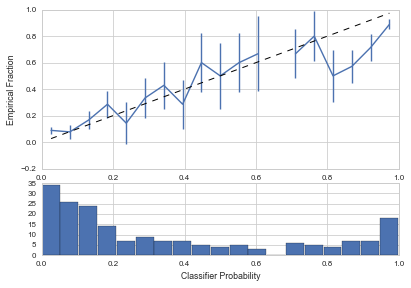

In [541]:
calibration_plot(clf, Xte, yte)

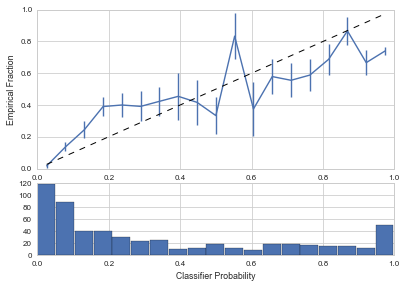

In [542]:
calibration_plot(clf, Xtr, ytr)

Notice how Naive bayes is more aptimistic at higher probabilities and less at lower probabilities. This is because of the conditional independence multiplication.

##Using pymc to do Bayesian statistics

Lets revert to standard Bayesian stats for a bit, where we have:

$$ p(\theta|D) = \frac{p(D|\theta)\,p(\theta)}{p(D)} $$

with the evidence $p(D)$ being given by the prior-predictive:

$$p(y) = \int d\theta p(y|\theta) p(\theta)$$ 

and predictions made by the posterior predictive:

$$p(y^* | D=\{y\}) = \int d\theta p(y^*|\theta)p(\theta|\{y\})$$.

(text taken from AM207)

###Gaussian with known $\sigma$

Define $\kappa=\frac{\sigma^2}{\tau^2}$ to be the variance of the sample model in units of variance of our prior belief (prior distribution) then the posterior mean

$$\mu_{p} = \frac{\kappa}{\kappa + n} \mu_{prior} + \frac{n}{\kappa + n} \bar{y}$$

which is a weighted average of prior mean and sampling mean. The variance is

$$\frac{1}{\tau_p^2} = \frac{1}{\tau^2} + \frac{1}{\sigma^2}$$

We have data on the wing length in millimeters of a nine members of a particular species of moth. We wish to make inferences from those measurements on the population mean $\mu$. Other studies show the wing length to be around 19 mm. We also know that the length must be positive. We can choose a prior that is normal and most of the density is above zero ($\mu=19.5,\tau=10$). The measurements were: 16.4, 17.0, 17.2, 17.4, 18.2, 18.2, 18.2, 19.9, 20.8 giving $\bar{y}=18.14$. 

Using the formulas above we have ($\kappa = \frac{\sigma^2}{100}$) and 
say $\sigma^2=s^2=1.9928$ then the posterior is $N(18.14,0.47)$. Note this is for a KNOWN $\sigma$.

In [32]:
Y = [16.4, 17.0, 17.2, 17.4, 18.2, 18.2, 18.2, 19.9, 20.8]
# Prior mean
mu_prior = 19.5
# prior std
tau = 10 
N = 15000

In [33]:
#Data Quantities
sig = np.std(Y) # assume that is the value of KNOWN sigma (in the likelihood)
mu_data = np.mean(Y)
n = len(Y)
kappa = sig**2 / tau**2
sig_post =np.sqrt(1./( 1./tau**2 + n/sig**2));
# posterior mean
mu_post = kappa / (kappa + n) *mu_prior + n/(kappa+n)* mu_data

#samples
theta_prior = np.random.normal(loc=mu_prior, scale=tau, size=N);
theta_post = np.random.normal(loc=mu_post, scale=sig_post, size=N);

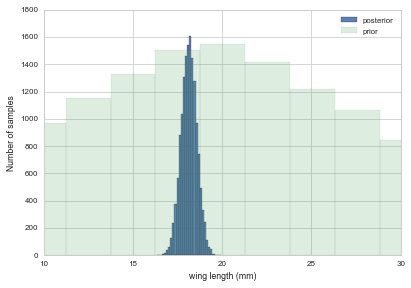

In [34]:
plt.hist(theta_post, bins=30, alpha=0.9, label="posterior");
plt.hist(theta_prior, bins=30, alpha=0.2, label="prior");
plt.xlim([10, 30])
plt.xlabel("wing length (mm)")
plt.ylabel("Number of samples")
plt.legend();

###Instead lets use pymc

In [128]:
from pymc import Normal, MCMC, Matplot, observed, deterministic, graph, stochastic


We put a normal prior on the mean as before, and fix the precision. The variables `means_pr` and `wingspans` are `Stochastics`. Notice `wingspans` have `observed=True` which indicates a likelihood. All Stochastics return log probabilities, but this is hidden from you for now.

In [129]:
means_pr=Normal('means_pr', mu=19.5, tau=0.01, value=20.)
wingspans = Normal('wingspans', mu=means_pr, tau=1/(sig*sig), value=Y, 
                    observed=True)

It might seem wierd to represent an observed thing, the `wingspans`, by a stochastic. But remember what Bayesian probability is: its not always the frequency estimate like the MLE in Naive Bayes, but rather something representative of our knowledge or uncertainty about a quantity.

Bayesian Notation thus does not differ between random variables and data. Thus we need to assign the likelihood a probability distribution as if it were a random variable. 

A way to get comfortable with this is to think of the generative aspect of statistical models: think of them as stories for data

Lets run the MCMC with the two variables. Pymc2 uses MH steps embedded in a Gibbs structure to go between variables. The method is to sample a suggestion from a normal distribution around the current value. If the suggestion improves the models log-probability, accept. But if it dosent, perhaps accept with acceptance proportional to how bad the new sample is.

In [131]:
M0 = MCMC([means_pr, wingspans])
M0.sample(iter=20000, burn=5000)

 [-----------------100%-----------------] 20000 of 20000 complete in 0.7 sec

The way it worls is by creating a DAG on the nodels in your graph. It figures out what are Stochastics and unobserved, and outputs traces for those. The graph structure is below (you will need to install pydot). You can also output parents and children.

In [136]:
dotm0=graph.dag(M0)

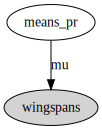

In [140]:
from IPython.display import SVG
SVG(dotm0.create_svg())

In [130]:
print means_pr.children, wingspans.parents
print means_pr.value, wingspans.value

set([<pymc.distributions.Normal 'wingspans' at 0x112278250>]) {'mu': <pymc.distributions.Normal 'means_pr' at 0x1123fca10>, 'tau': 0.56453861165319197}
20.0 [ 16.4  17.   17.2  17.4  18.2  18.2  18.2  19.9  20.8]


this is how you plot the marginal, trace, and acorr for a stochastic:

Plotting means_pr


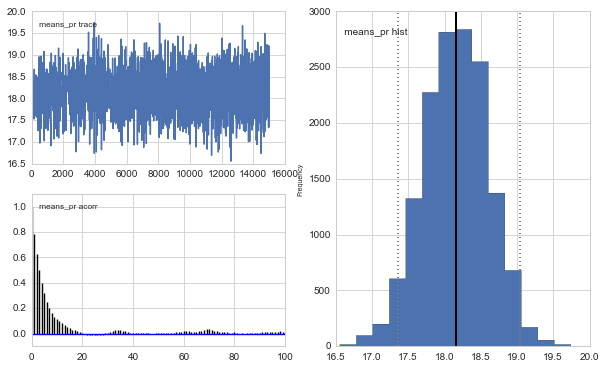

In [39]:
Matplot.plot(means_pr)

And below is how u get the trace out. You can also use `means_pr.trace()`. Note that in this form you use the string name of the stochastic, whereas in the latter you use the variable name.

In [132]:
M0.trace('means_pr')[:]

array([ 18.197082  ,  18.197082  ,  18.197082  , ...,  17.40876589,
        18.14956583,  17.75870891])

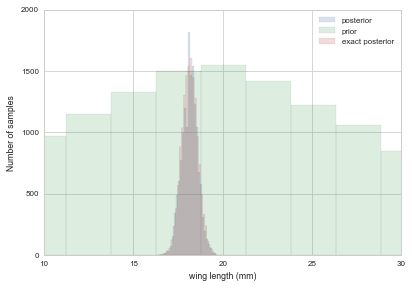

In [133]:
plt.hist(M0.trace('means_pr')[:], bins=30, alpha=0.2, label="posterior");
plt.hist(theta_prior, bins=30, alpha=0.2, label="prior");
plt.hist(theta_post, bins=30, alpha=0.2, histtype="stepfilled", label="exact posterior");

plt.xlim([10, 30])
plt.xlabel("wing length (mm)")
plt.ylabel("Number of samples")
plt.legend();

### Joint distribution of mean and variance

But how about if we did not know $\sigma^2$? Note:

$$p(\theta, \sigma^2) = p(\theta | \sigma^2) \; p(\sigma^2) $$

One can mathematically work it out. 

For $\sigma^2$ we need a prior that covers (0,$\infty$). One option is the gamma family. Unfortunately 
this is not conjugate for the normal. However it turns out to be conjugate for pdf of $1/\sigma^2$. This is called the __inverse-gamma__ distribution:

$$ p(\sigma^2) \sim \rm{inversegamma}(a,b) $$


Under this parametrization $ E[\sigma^2] = \frac{b}{a-1} $. 

Let our prior have this form 

$$ p(\sigma^2) \sim \rm{inversegamma}( \frac{ \nu}{2}, \frac{\nu \sigma_0^2}{2}) $$

and we know the conditional prior  of $\theta$ 

$$ p( \theta | \sigma^2) \sim N (\mu, \sigma^2/\kappa) $$

This joint prior can be  decomposed 
as $p(\theta, \sigma^2)=p(\theta| \sigma^2) p(\sigma^2) $, and therefore  the posterior can be similarly 
decomposed: 

$$ p(\theta, \sigma^2 | y_1,\ldots,y_n) = p( \theta | \sigma^2) \; p(\sigma^2 ) p(y_1\ldots,y_n \vert \sigma^2, \theta)$$

The conditional distribution of $\theta$ given the data and $\sigma^2$ can be obtained using 
the results of the previous section. 
The posterior distribution of $\sigma^2$ can be obtained by performing an integration over known 
values of $\theta$: 

$$ p(\sigma^2|y_1, \ldots, y_n) \sim p(\sigma^2) p(y_1, \ldots, y_n | \sigma^2)  
= p(\sigma^2) \int p(y_1, \ldots, y_n | \theta, \sigma^2 ) \, p(\theta | \sigma^2) d\theta 
 $$

One can integrate this (left as an exercise) but the result is:

$$ p(1/\sigma^2| y_1, \ldots, y_n) \sim \rm{gamma}(\nu_{n} /2, \nu_{n} \sigma^2_{n}/2) $$
where 

$$ \nu_n = \nu+n $$ 

$$ \sigma_n^2 = \frac{1}{\nu_n} \left[  \nu \sigma_0^2 +(n-1) \, s^2 + \frac{ \kappa n }{\kappa+ n}(\bar{y} - \mu)^2 \right] $$

and $s^2$ is the sample variance. 

### Example: Moth wing example (joint distribution):

Studies of other populations suggest that the true
mean and standard deviation of our population under study should not be 
too far the sample mean. We use here $\mu=19$ and $\sigma_0^2 = 2$.
This population may be different from others so we choose $\kappa = \nu=1$.
The sample mean $\bar{y} = 18.14$ and sample variance $s^2=1.9928$.
We can compute the posterior means 

$$ \mu_p = \frac{\kappa}{\kappa+n} \mu  + \frac{n}{\kappa+n} \bar{y}  = 18.2260 $$

$$ \sigma_p^2 = \frac{1}{\nu_n}  \left[ \nu \sigma_0^2  + (n-1) s^2 + \frac{\kappa \, n}{\kappa + n} (\bar{y} - \mu)^2 \right] = 1.8606 $$ 

So the posterior distribution is determined by the values $\mu_p= 18.2260, \kappa =1 , \sigma_p^2 = 1.8606, \nu=1 $.
Let $\hat{\sigma}^2= 1/\sigma^2$ we can create a contour plot for example by computing (NOT SAMPLING)

$$ N\left(\theta_k \mu_p, 1/\sqrt{10 \hat{ \sigma}_l^2} \right) \times \rm{gamma}\left(\hat{\sigma}_l^2, 10/2, 10 \sigma_p^2/2 \right) $$

for each pair $\theta_k, \hat{\sigma}_l^2 $ on a grid. 

But given that we are interested in sampling, note that the precision ($\frac{1}{\sigma^2}$) is thus conjugate to the gamma. Lets look at a reasonably un-informative gamma. 

(0, 100)

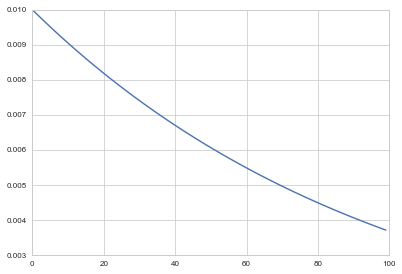

In [119]:
x=np.arange(0,100,1)
gam=sp.stats.gamma(1.0000000, scale=1./0.01)
plt.plot(x, gam.pdf(x))
plt.xlim([0,100])

Now let us set up a model for this, This time the precision also has a prior. Notice the structure of the parent and child relationships.

In [142]:
from pymc import Gamma
tau_pr=Gamma('tau_pr', alpha=1.0, beta=0.01)
means_pr=Normal('means_pr', mu=19.5, tau=0.01, value=20.)
wingspans = Normal('wingspans', mu=means_pr, tau=tau_pr, value=Y, 
                    observed=True)
print means_pr.children, means_pr.parents, wingspans.parents


set([<pymc.distributions.Normal 'wingspans' at 0x1126faf10>]) {'mu': 19.5, 'tau': 0.01} {'mu': <pymc.distributions.Normal 'means_pr' at 0x1120e42d0>, 'tau': <pymc.distributions.Gamma 'tau_pr' at 0x112e436d0>}


In [143]:
M = MCMC([tau_pr, means_pr, wingspans])
M.sample(iter=70000, burn=10000, thin=5)

 [-----------------100%-----------------] 70000 of 70000 complete in 3.8 sec

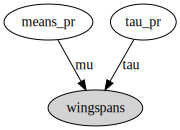

In [146]:
dotm=graph.dag(M)
SVG(dotm.create_svg())

Plotting means_pr


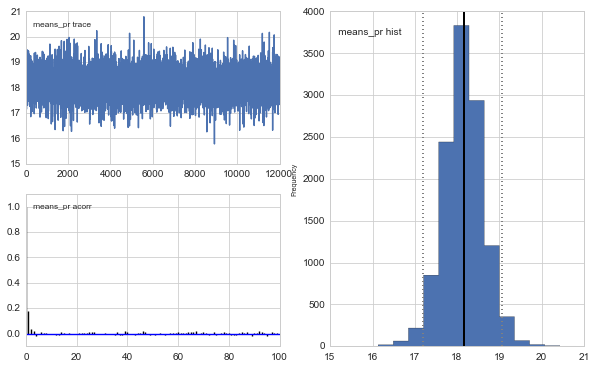

In [144]:
Matplot.plot(means_pr)

Plotting tau_pr


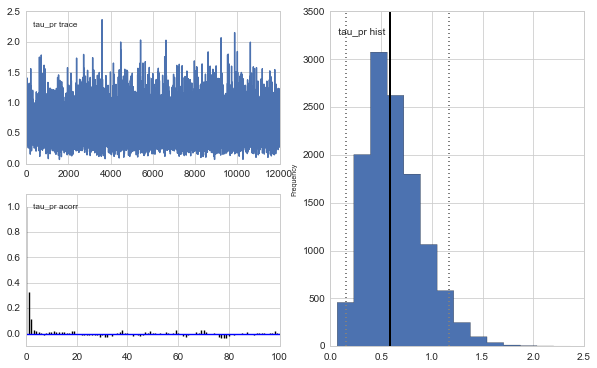

In [145]:
Matplot.plot(tau_pr)

As another test of convergence we can check that the geweke statistic is within 2 $\sigma$:

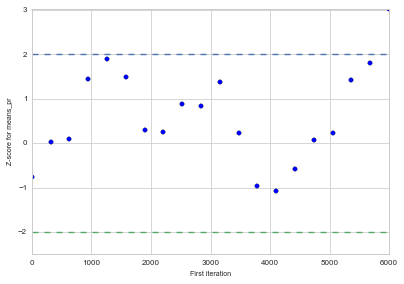

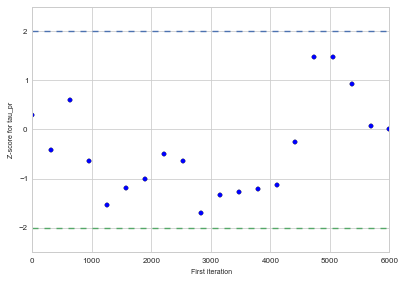

In [544]:
from pymc import geweke
gM=geweke(M)
Matplot.geweke_plot(gM)

##Unsupervised Learning

Before we go into supervized learning using bayesian methods at different levels, lets briefly visit unsupervised learning. There is no explicit external risk corresponding to an external decision, but rather a density estimation problem for $p(x)$.

Note that if you do have classes in the problem, as we shall see below, then we have

$$p(x) = \sum_c p(x|c) p(c).$$

In other words we discover the marginal p(x) through the generative model and thus discover **outliers** in our data.


In [149]:
from pymc import Categorical, Uniform

In [360]:
ofdata=pd.read_csv("https://dl.dropboxusercontent.com/u/75194/oldfaithful.csv")
ofdata.head()

,eruptions,waiting
0,3.600,79
1,1.800,54
2,3.333,74
3,2.283,62
4,4.533,85


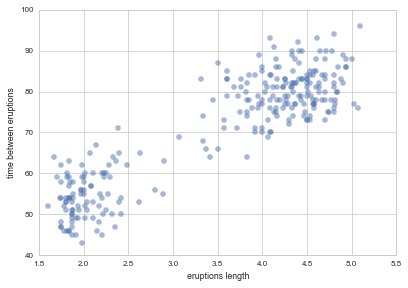

In [363]:
plt.plot(ofdata.eruptions, ofdata.waiting,'o',alpha=0.5);
plt.xlabel('eruptions length')
plt.ylabel('time between eruptions')

Even if we do not know of the existence of classes in our data, we can consider a hidden parameter $z$ such that:

$$p(x) = \sum_z p(x|z) p(z).$$

This is the thinking behind mixture models which are very highly used to describe all kinds of data. Even hierarchical models can be thought of as continuous mixtures so the lessons learnt with mixture models are useful. in AM207 you will learn how to solve then using EM on likelihoods or posteriors. We demonstrate this quickly in scikit-learn, below.

###One could use frequentist EM

In [368]:
from sklearn import mixture
clf = mixture.GMM(n_components=2, covariance_type='tied')
vals=ofdata.values
clf.fit(vals)

GMM(covariance_type='tied', init_params='wmc', min_covar=0.001,
  n_components=2, n_init=1, n_iter=100, params='wmc', random_state=None,
  thresh=0.01)

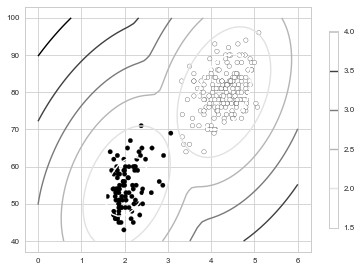

In [369]:
mask = clf.predict(vals)
xx = np.linspace(0, 6) 
yy = np.linspace(40, 100) 
X, Y = np.meshgrid(xx, yy)
XX = np.c_[X.ravel(), Y.ravel()]
Z =  np.log(-clf.score_samples(XX)[0])
Z = Z.reshape(X.shape)

CS = plt.contour(X, Y, Z)
CB = plt.colorbar(CS, shrink=0.8, extend='both')
plt.scatter(ofdata.eruptions, ofdata.waiting, c=mask);

But EM is an optimization algorithm and is as such restricted to providing us with point estimates rather than samples. Now that we are into the belly of MCMC sampling: a very reasonable question to ask is this: whats the uncertainty on the probability estimates bayesian learning gives us? Note that both discriminative and generative models (like naive bayes) can be set up perfectly well with point estimates, but we now want to take our bayesianness to the next level.

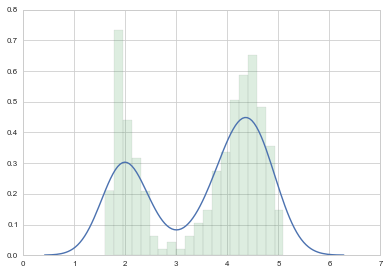

In [411]:
elvals=ofdata.eruptions.values
sns.kdeplot(elvals)
plt.hist(elvals, normed=True, alpha=0.2, bins=20);

Lets do the problem in one dimension, the dimension of eruptions, for simplicity. The code for this and the subsequentl supervixed learning problem is largely stolen from CDP's excellent Bayesian Methods for Hackers, which along with Fonnesbeck's Bios366 repo (from which the code for the bioassay problem is taken) are MUST READS.

###Or one can use MCMC

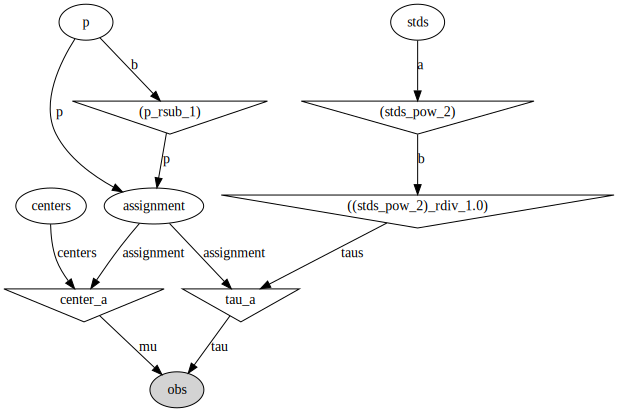

In [404]:
p = Uniform("p", 0, 1)
assignment = Categorical("assignment", [p, 1 - p], size=elvals.shape[0] )
taus = 1.0 / Uniform("stds", 0.1, 4, size=2) ** 2
centers = Normal("centers", [2., 4.7], [0.1, 0.1], size=2)

"""
The below deterministic functions map an assignment, in this case 0 or 1,
to a set of parameters, located in the (1,2) arrays `taus` and `centers`.
"""

@deterministic
def center_a(assignment=assignment, centers=centers):
    return centers[assignment]

@deterministic
def tau_a(assignment=assignment, taus=taus):
    return taus[assignment]
observations = Normal("obs", center_a, tau_a, value=elvals, observed=True)
from pymc import Model
model = Model([p, assignment,  observations, taus, centers])
mcmc = MCMC(model)
dotmcmc=graph.dag(mcmc)
SVG(dotmcmc.create_svg())

In [405]:
mcmc.sample(300000, burn=200000, thin=5)

 [-----------------100%-----------------] 300000 of 300000 complete in 99.3 sec

Plotting stds_0
Plotting stds_1
Plotting centers_0
Plotting centers_1
Plotting p


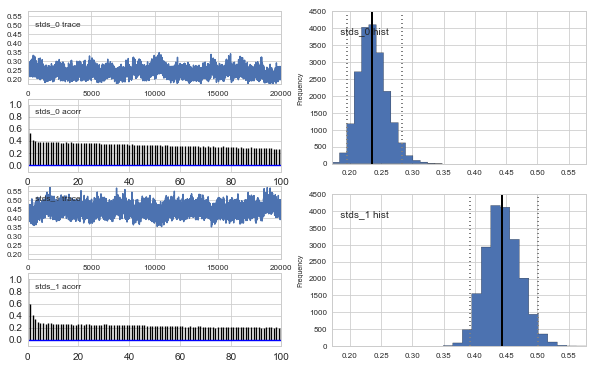

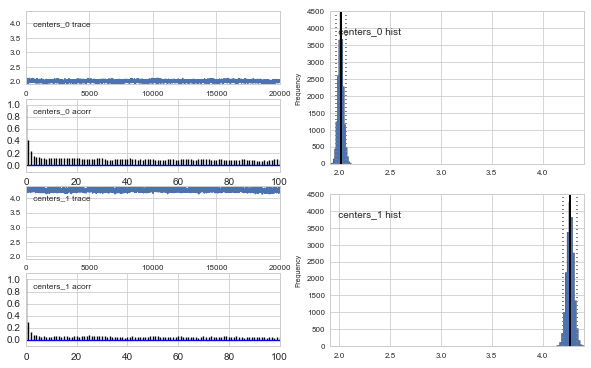

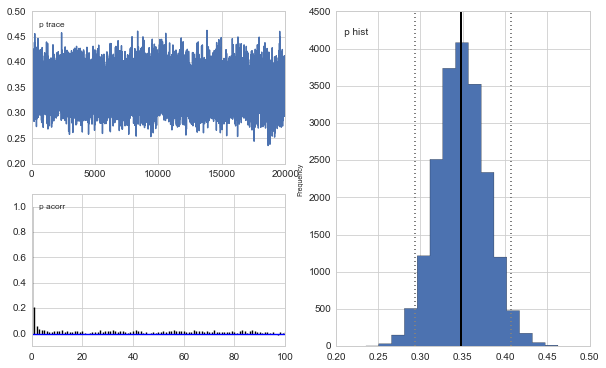

In [406]:
Matplot.plot(mcmc)

Note that because we have done MCMC, each sample in a trace corresponds to a set of values for the parameters. So we literally have 100,000 gaussian mixture models here. How to make any sense of this? We'll take the point estimates from the means of the parameters and draw us a set of clusters, forgetting to do any inference on these clusters for now. The posterior predictive at any x not in the training sample (and in the training sample if you like) would be the one which **marginalizes** over all the 100000 parameter values. 

Lets do the simpler hacky means thing:

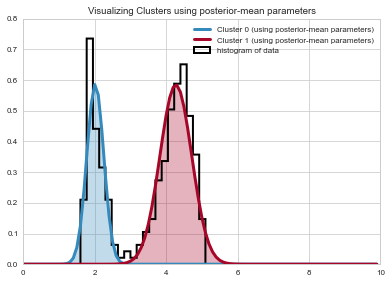

In [407]:
center_trace = mcmc.trace("centers")[:]
std_trace = mcmc.trace("stds")[:]
colors = ["#348ABD", "#A60628"] \
if center_trace[-1, 0] > center_trace[-1, 1] \
    else ["#A60628", "#348ABD"]
norm = sp.stats.norm
x = np.arange(0, 10, 0.1)
posterior_center_means = center_trace.mean(axis=0)
posterior_std_means = std_trace.mean(axis=0)
posterior_p_mean = mcmc.trace("p")[:].mean()


y = posterior_p_mean * norm.pdf(x, loc=posterior_center_means[0],
                                scale=posterior_std_means[0])
plt.plot(x, y, label="Cluster 0 (using posterior-mean parameters)", color=colors[1], lw=3)
plt.fill_between(x, y, color=colors[1], alpha=0.3)

y = (1 - posterior_p_mean) * norm.pdf(x, loc=posterior_center_means[1],
                                      scale=posterior_std_means[1])
plt.plot(x, y, label="Cluster 1 (using posterior-mean parameters)", color=colors[0], lw=3)
plt.fill_between(x, y, color=colors[0], alpha=0.3)
plt.hist(elvals, bins=20, histtype="step", normed=True, color="k",
     lw=2, label="histogram of data")
plt.legend(loc="upper right")
plt.title("Visualizing Clusters using posterior-mean parameters")

Voila, a pretty reasonable density estimate or hidden variables (really classes) based mixture estimate of the density p(x), one might say...

##A simple regression: the old bioassay

Remember the old Gelman Bioassy? Various drug doses are administered to animals and a binary outcome (death) is noted. There are 4 groups of 5 animals each, different doses administered, and deaths recorded. We construct a model for $\theta$ the binomial probabiliy of death, as a regression on dose through the logit link function. We set imprecise normal priors on the regression coefficients, and pass the linear regression through the inverse logit function into a binomial likelihood.

In [545]:
from pymc import Normal, Binomial, deterministic, invlogit, Model, MAP

n = [5]*4 
dose = [-.86,-.3,-.05,.73] 
x = [0,1,3,5]
alpha = Normal('alpha', mu=0.0, tau=0.01) 
beta = Normal('beta', mu=0.0, tau=0.01)

@deterministic 
def theta(a=alpha, b=beta, d=dose):
    """theta = inv_logit(a+b)""" 
    return invlogit(a+b*d)

# deaths ~ binomial(n, p), 4 of them
deaths = Binomial('deaths', n=n, p=theta, value=x, observed=True)

###Posterior predictive

We add an interesting new stochastic to the model, `deaths_sim`, the simulated deaths, in order to do posteror predictive modelling. This is using the model in a generative sense, by simulating new data from it, or, if you like finding the posterior prediction at new x.

If you think about it for a second, you'll realize that you can lump the posterior prediction needed 'likelihoods' along with the other stochastics. Then, by just getting the trace of these points, you will have the marginal over all the other stochastics, which is precisely what you want.

If you think about it a little more, this technique of using the posterior predictive can be used to fill missing data points in a data set. Indeed, pymc can take numpy masked arrays for precisely this purpose. We wont do that here but see the docs.

In [547]:
deaths_sim = Binomial('deaths_sim', n=n, p=theta)#4 of them

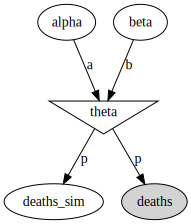

In [548]:
bioassay_model=Model([alpha, beta, theta, deaths, deaths_sim])
dotbioassay=graph.dag(bioassay_model)
SVG(dotbioassay.create_svg())

In [549]:
map_ = MAP(bioassay_model)
map_.fit(method='fmin_powell')
bioassay_mcmc = MCMC(bioassay_model)
bioassay_mcmc.sample(10000, 5000, 2)

 [-----------------100%-----------------] 10000 of 10000 complete in 2.1 sec

Plotting deaths_sim_0
Plotting deaths_sim_1
Plotting deaths_sim_2
Plotting deaths_sim_3
Plotting beta
Plotting theta_0
Plotting theta_1
Plotting theta_2
Plotting theta_3
Plotting alpha


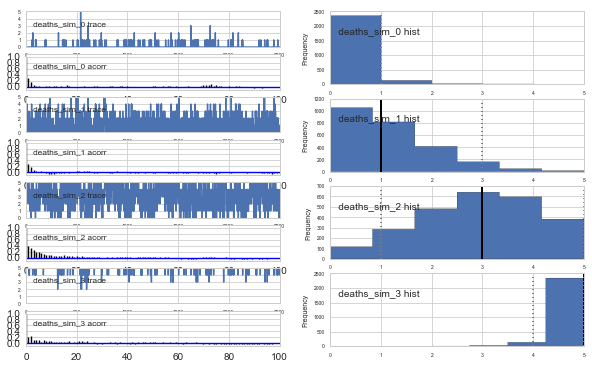

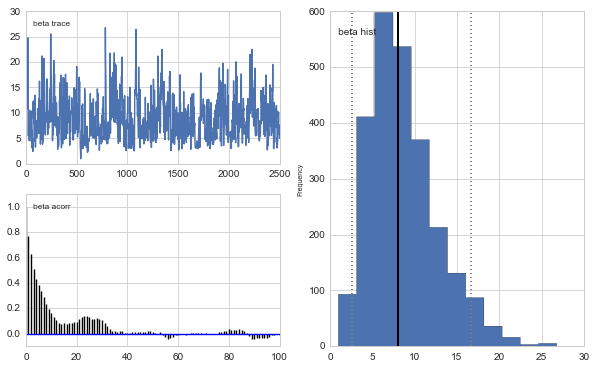

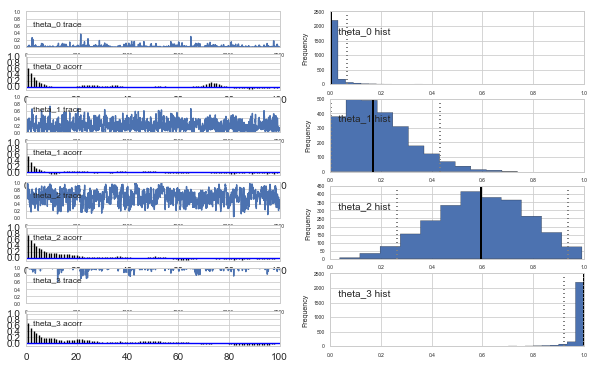

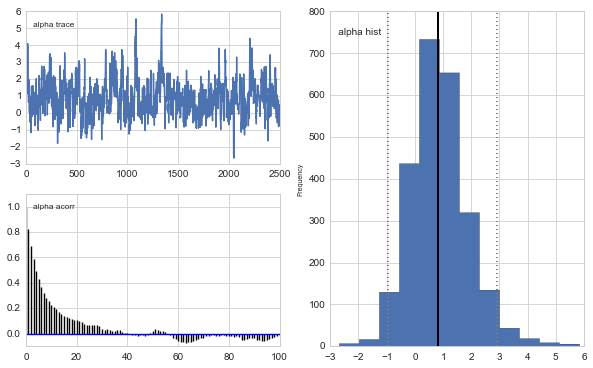

In [550]:
Matplot.plot(bioassay_mcmc)

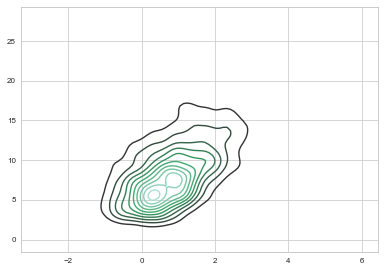

In [551]:
sns.kdeplot(alpha.trace(), beta.trace())

You can summarise the MCMC with the credible intervals for the traces

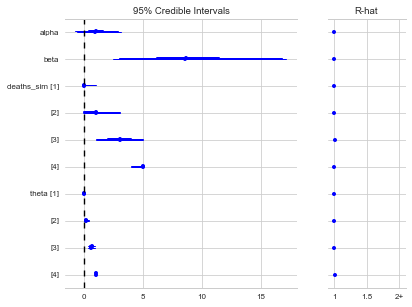

In [519]:
Matplot.summary_plot(bioassay_mcmc)

One can use the simulated data, the posterior predictive values, to make a discrepancy plot. The discrepancy calculates the difference between data/simulation tot he expected values from the model. A discrepancy plot plots the simulated discrepancy against the observed discrepancy. These should bunch around the 45 degree line.

The discrepancy is defined using the the Freeman-Tukey statistic:

$$D(x|\theta) = \sum_j (\sqrt{x_j} -\sqrt{e_j})^2$$

The average difference between the simulated and observed discrepancy ought to be zero. The Bayesian p value is the proportion of simulated discrepancies that are larger than their corresponding observed discrepancies. If p is very large or very small the model is not consistent with the data. This is pointing to lack of fit.

Bayesian p-value: p=0.564
Plotting discrepancy-gof


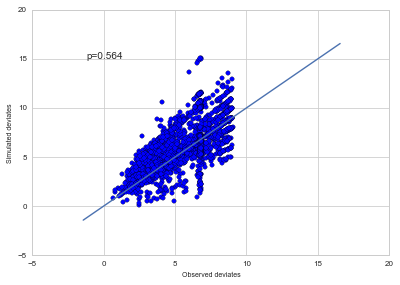

In [532]:
from pymc import discrepancy

expected = theta.trace
#observed, simulated, modelexpected
d = discrepancy(x, deaths_sim, (theta.trace() * n).T)
#print d[0][:10], d[1][:10]
Matplot.discrepancy_plot(d)

##Supervised Learning

With that little diversion on how to model posterior-predictives in pymc, we turn our attention to carrying out a very bayesian supervised learning which will not only use a generative model and thus use bayesian decision theory, but also generate enough samples so that we can do onference if we so desire.

We use the heights-weights data set as we do have a story for why these outght to be separately gaussianly distributed for men and women.

In [556]:
df=pd.read_csv("https://dl.dropboxusercontent.com/u/75194/stats/data/01_heights_weights_genders.csv")
df.head()

,Gender,Height,Weight
0,Male,73.847017,241.893563
1,Male,68.781904,162.310473
2,Male,74.110105,212.740856
3,Male,71.730978,220.042470
4,Male,69.881796,206.349801


In [557]:
df.describe()

,Height,Weight
count,10000.000000,10000.000000
mean,66.367560,161.440357
std,3.847528,32.108439
min,54.263133,64.700127
25%,63.505620,135.818051
50%,66.318070,161.212928
75%,69.174262,187.169525
max,78.998742,269.989699


In [558]:
np.mean(df.Gender=='Male')

0.5

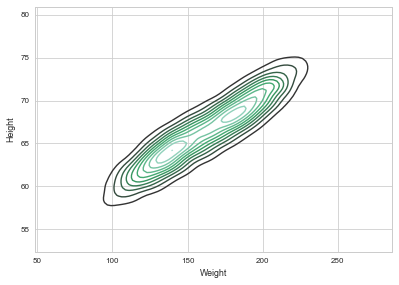

In [559]:
sns.kdeplot(df.Weight, df.Height)

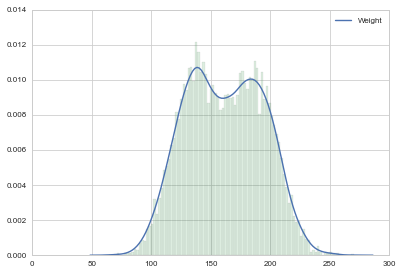

In [560]:
sns.kdeplot(df.Weight)
plt.hist(df.Weight, bins=100, alpha=0.2, normed=True);

We'll stick to one dimension since, as before, we'd like to keep things simple. Note that this is a hard set of gaussians to separate (estimating p(x) as a mixture will be hard if we just had the latent, but not the class structure), and having training points will help tease the gaussians just right. 

We do the train-test split

In [562]:
datax=df.Weight.values
dataz=1*(df.Gender=='Male')
from sklearn.cross_validation import train_test_split
itr, ite = train_test_split(range(dataz.shape[0]), train_size=0.7)
xte=datax[ite]
xtr=datax[itr]
zte=dataz[ite]
ztr=dataz[itr]
# nonedz=np.empty(data.shape[0])
# nonedz[itr]=dataz[itr]
# nonedz[ite]=[999]*len(ite)
# print nonedz
# masked_zs = np.ma.masked_equal(nonedz, value=999.)
# masked_zs

We use 2-D categoricals tomake cluster assignments as before. Nut notice that the training assignments are an observed stochastic where as the testing are not. We want the trace of the testing assignments. That is we want p(c|x) and we'll use the MCMC model to dothe whole bayes theorem inversion for us!

In [563]:
p = Uniform("p", 0.1, 0.9)

assignment_tr = Categorical("assignment_tr", [p, 1 - p], value=ztr, observed=True)
assignment_te = Categorical("assignment_te", [p, 1 - p], size=zte.shape[0])

print "prior assignment, with p = %.2f:" % p.value
print assignment_te.value[:10], "..."

prior assignment, with p = 0.41:
[1 0 1 0 1 0 1 1 1 1] ...


In [564]:
taus = 1.0 / Uniform("stds", 20, 70, size=2) ** 2
centers = Normal("centers", [130, 170], [0.01, 0.01], size=2)

"""
The below deterministic functions map an assignment, in this case 0 or 1,
to a set of parameters, located in the (1,2) arrays `taus` and `centers`.
"""

@deterministic
def center_i(assignment=assignment_tr, centers=centers):
    return centers[assignment]

@deterministic
def tau_i(assignment=assignment_tr, taus=taus):
    return taus[assignment]

@deterministic
def center_ite(assignment=assignment_te, centers=centers):
    return centers[assignment]

@deterministic
def tau_ite(assignment=assignment_te, taus=taus):
    return taus[assignment]

print "Assigned center: ", center_i.value[:4], "..."
print "Assigned precision: ", tau_i.value[:4], "..."

Assigned center:  [ 178.54057976  148.28371366  148.28371366  148.28371366] ...
Assigned precision:  [ 0.00192944  0.00141612  0.00141612  0.00141612] ...


In [565]:
xte.shape, xtr.shape

((3000,), (7000,))

And nor notice we have two sets of x data, the training and the observations, which refer to different deterministics and thus different subgraphs.

In [566]:
# and to combine it with the observations:
observations_tr = Normal("obs_tr", center_i, tau_i, value=xtr, observed=True)
observations_te = Normal("obs_te", center_ite, tau_ite, value=xte, observed=True)


# below we create a model class
from pymc import Model
model = Model([p, assignment_tr, assignment_te, observations_tr, observations_te, taus, centers])
#model = Model([p, assignment_tr, observations_tr,  taus, centers])

The entire graph can be seen below, and has as its likelyhood p(xtr|ctr) and we can just sample the cte node to get the appropriately bayes theorem inverted p(cte|xte) from our generative model. And because it gives us the posterior predictive it **automatically marginalizes** over all our statistics making us not have to worry about parameter traces.

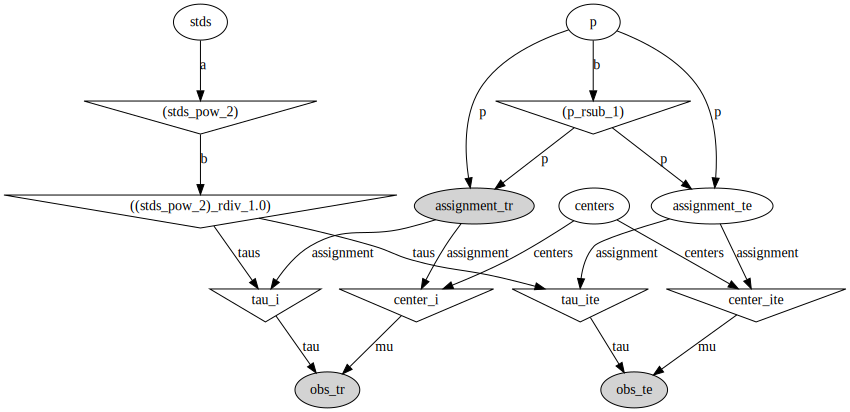

In [567]:
mcmc = MCMC(model)
dotmcmc=graph.dag(mcmc)
SVG(dotmcmc.create_svg())

The sampler takes a long time, even with narrow priors and training, because we asked to estimate 3000 posterior predictives for assignment.

In [568]:
mcmc.sample(400000, burn=200000, thin=5)

 [-----------------100%-----------------] 400000 of 400000 complete in 423.2 sec

Plotting p
Plotting stds_0
Plotting stds_1
Plotting centers_0
Plotting centers_1


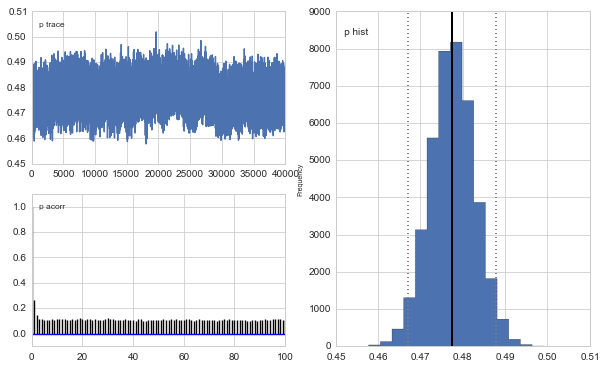

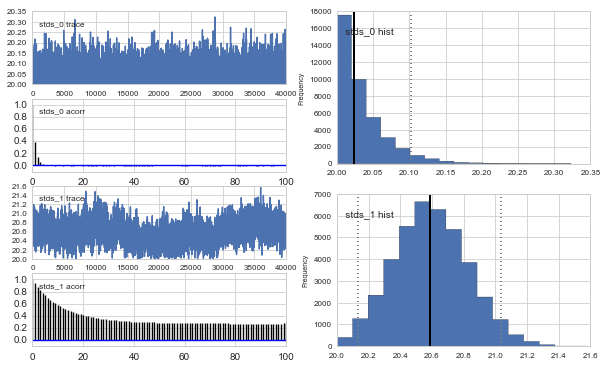

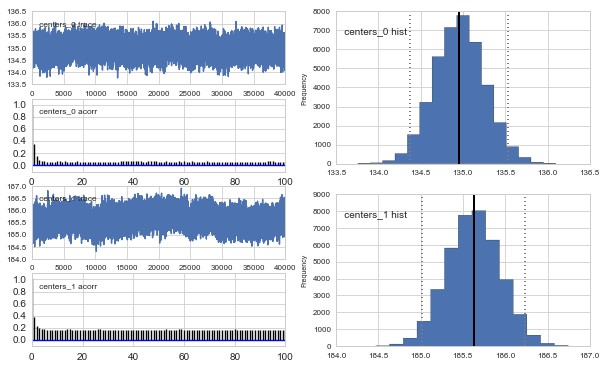

In [569]:
Matplot.plot(mcmc, common_scale=False)

In [570]:
mcmc.trace("assignment_te")[:].shape

(40000, 3000)

Ok so it gave us 3000 distributions for p(c|x) on the testing points.

In [571]:
center_trace = mcmc.trace("centers")[:]
std_trace = mcmc.trace("stds")[:]
colors = ["#348ABD", "#A60628"] \
if center_trace[-1, 0] > center_trace[-1, 1] \
    else ["#A60628", "#348ABD"]

In [572]:
colors

['#A60628', '#348ABD']

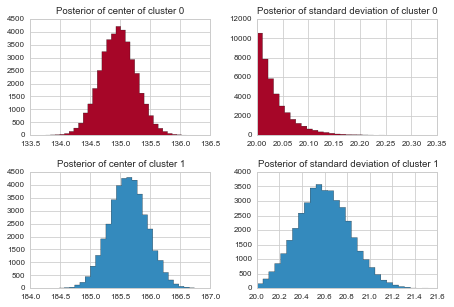

In [573]:
_i = [1, 2, 3, 0]
for i in range(2):
    plt.subplot(2, 2, _i[2 * i])
    plt.title("Posterior of center of cluster %d" % i)
    plt.hist(center_trace[:, i], bins=30, color=colors[i],
             histtype="stepfilled")

    plt.subplot(2, 2, _i[2 * i + 1])
    plt.title("Posterior of standard deviation of cluster %d" % i)
    plt.hist(std_trace[:, i], bins=30, color=colors[i],
             histtype="stepfilled")
    # plt.autoscale(tight=True)

plt.tight_layout()

We play the same means game on the training data.

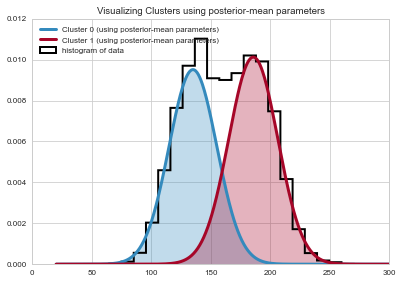

In [575]:
norm = sp.stats.norm
x = np.linspace(20, 300, 500)
posterior_center_means = center_trace.mean(axis=0)
posterior_std_means = std_trace.mean(axis=0)
posterior_p_mean = mcmc.trace("p")[:].mean()

plt.hist(xtr, bins=20, histtype="step", normed=True, color="k",
     lw=2, label="histogram of data")
y = posterior_p_mean * norm.pdf(x, loc=posterior_center_means[0],
                                scale=posterior_std_means[0])
plt.plot(x, y, label="Cluster 0 (using posterior-mean parameters)", color=colors[1], lw=3)
plt.fill_between(x, y, color=colors[1], alpha=0.3)

y = (1 - posterior_p_mean) * norm.pdf(x, loc=posterior_center_means[1],
                                      scale=posterior_std_means[1])
plt.plot(x, y, label="Cluster 1 (using posterior-mean parameters)", color=colors[0], lw=3)
plt.fill_between(x, y, color=colors[0], alpha=0.3)

plt.legend(loc="upper left")
plt.title("Visualizing Clusters using posterior-mean parameters")

When we plot the test data asssignments against the test data set, a familiar curve shows up: that of the logistic. That in itself is not surprising. The discriminant counterpart to LDA in 2D or 1D models with mixtures would be expected to be like a logistic.

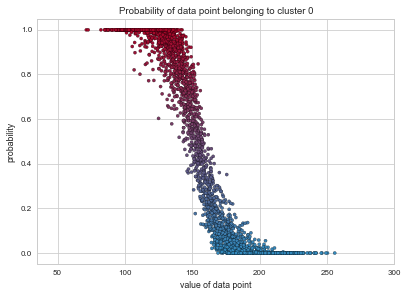

In [576]:
cmap = mpl.colors.LinearSegmentedColormap.from_list("BMH", colors)
assign_trace = mcmc.trace("assignment_te")[:]
plt.scatter(xte, 1 - assign_trace.mean(axis=0), cmap=cmap,
        c=assign_trace.mean(axis=0), s=10)
plt.ylim(-0.05, 1.05)
plt.xlim(35, 300)
plt.title("Probability of data point belonging to cluster 0")
plt.ylabel("probability")
plt.xlabel("value of data point")

In [577]:
zpred=1*(assign_trace.mean(axis=0) > 0.5)
confusion_matrix(zpred, zte)

array([[1262,   74],
       [ 284, 1380]])

Indeed multiple generative models can give rise to the same dicriminative model. Consider this example from bishop:

![gen and dis](https://dl.dropboxusercontent.com/u/75194/bishopgendis.png)

We can see the confusion matrix for our classifier

###Generative vs Discriminative, redux

From Barber, again.
![gen vs dis](https://dl.dropboxusercontent.com/u/75194/genvsdis.png)

This is perhaps the right time then to revisit the generative vs discriminative argument, now that we have some experience under our belt.

- If we only wish to make classification decisions rather than more complex decisions then discriminative might be all we need, and it is cheaper in terms of computing resources. But asymmetry and the ability to generate synthetic data are strengths of the generative approach.
- sometimes generative models like LDA and Naive Bayes are easy to fit. The discriminative model LogisticRegression requires convex optimization via Gradient descent
- we can add new classes toa generative classifier withoutretraining for the previous classes so it might be better for online customer selection problems where customer profiles change
- generative classifiers can handle missing data easily
- generative classifiers are better at handling unlabelled training data (semi-supervized learning)
- preprocessing data is easier with discriminative classifiers
- discriminative classifiers give generally better callibrated probabilities

##Coda

As a coda and to round back to the question as to what I ought to do about cancer, let me come back to an example from Barber.

![cancer example](https://dl.dropboxusercontent.com/u/75194/cancerexample.png)

What to use? Both approaches are heavily used in practise. The Bayesian one is regularized using the empirical risk to control the possible mis-specification problems. Similarly one can modify the extreme empirical approach by putting distributional assumptions on p(x,y)